In [1]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

True

In [2]:
llm = ChatOpenAI(model="gpt-4o")

In [3]:
# Schema for structured output
from pydantic import BaseModel, Field
from langchain_community.tools import TavilySearchResults


class SearchQuries(BaseModel):
    search_query: list = Field(
        None, description="List of Queries that are optimized for web search."
    )
    justification: list = Field(
        None, description="Why each query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuries)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")


# Define a tool
tavily_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([tavily_tool])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke(
    "nvidia 주가 하락의 원인이 된 대상 이름이 뭐야?그리고 그 대상에 대한 정보 알려줘"
)

# Get the tool call
msg.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'Nvidia 주가 하락 원인'},
  'id': 'call_lZpSuT7Fy08MyDWAV7Ei2AS2',
  'type': 'tool_call'}]

In [4]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


class SearchQury(BaseModel):
    search_query: str = Field(
        None, description="Query that is optimized for web search."
    )
    justification: str = Field(
        None, description="Why query is relevant to the user's request."
    )


class Reference(BaseModel):
    """Model for a reference"""

    title: str = Field(description="The title of the reference.")
    url: str = Field(description="The url of the reference.")


# Graph state
class State(TypedDict):
    search_queries: list[SearchQury]

    combined_output: str



In [5]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

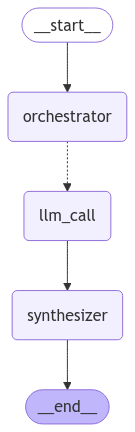

In [6]:
from langgraph.constants import Send
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage

# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))


In [7]:
# Invoke
for chunk in orchestrator_worker.stream({"topic": "Create a report on LLM scaling laws"}, stream_mode=["updates"]):
    print(chunk)


('updates', {'orchestrator': {'sections': [Section(name='Introduction to LLM Scaling Laws', description='This section will provide an overview of what LLM scaling laws are, their significance in the development of large language models, and a brief history of their discovery and evolution.'), Section(name='Mathematical Foundations', description='Discuss the mathematical theories and principles underlying LLM scaling laws, including key equations and models used to predict the performance of language models based on their size and training data.'), Section(name='Empirical Evidence', description='Present empirical studies and experiments that have validated LLM scaling laws, highlighting specific cases and outcomes that demonstrate the laws in action.'), Section(name='Applications and Implications', description='Analyze how LLM scaling laws impact the design and deployment of language models, including practical applications in AI systems and potential implications for future model devel

In [8]:

from IPython.display import Markdown

Markdown(state["final_report"])

NameError: name 'state' is not defined

In [18]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class SearchQuery(BaseModel):
    query: str = Field(None, description="Query that is optimized for web search.")
    justification: str = Field(
        None, description="Why query is relevant to the user's request."
    )


class SearchQueries(BaseModel):
    queries: List[SearchQuery] = Field(
        description="List of search queries and their justifications.",
    )


class Reference(BaseModel):
    """Model for a reference"""

    title: str = Field(description="The title of the reference.")
    url: str = Field(description="The url of the reference.")
    content: str = Field(description="The content of the reference.")
    summary: str = Field(description="The summary of the reference.")


class State(TypedDict):
    question: str  # The difficult question to answer
    queries: List[SearchQuery]  # List of generated search queries
    references: Annotated[
        list, operator.add
    ]  # Aggregated search results from tavily tool
    final_answer: str  # Final synthesized answer


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(SearchQueries)

In [ ]:
from langgraph.constants import Send, START, END
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage
from typing_extensions import TypedDict
from langchain_core.runnables import RunnableConfig


class WorkerState(TypedDict):
    query: SearchQuery  # The search query for this worker
    completed_results: Annotated[
        list, operator.add
    ]  # Shared list for aggregating results


# Node: Orchestrator
def orchestrator(state: State) -> dict:
    """
    Generate a set of search queries based on the difficult question

    - Use the planner LLM to generate queries
    - Return the generated queries list under key 'queries'
    """
    generated = planner.invoke(
        [
            SystemMessage(
                content="Generate a list of search queries that are required to answer the difficult question"
            ),
            HumanMessage(content=f"Here is the question: {state['question']}"),
        ]
    )
    # Assume that the planner returns an object with an attribute 'queries' that is a list of Query
    return {"queries": generated.queries}


# Node: Worker using the tavily tool
def web_search(state: WorkerState) -> dict:
    """
    Execute a search for the provided query using the tavily tool

    - Extract the query text from the state
    - Invoke the tavily search tool with the query
    - Return the search result as part of completed_results
    """
    query_text = state["query"].query  # Use attribute access instead of subscripting
    search_result = tavily_tool.invoke(query_text)
    references = List(Reference())
    for search in search_result:
        references.append(
            Reference(
                title=search.title,
                url=search.url,
                content=search.content,
            )
        )
    return {"references": references}


async def summarization_node(state: WorkerState, config: RunnableConfig):
    """
    The summarization node is responsible for extracting and summarizing information from a web search.
    """

    system_message = f"""
This is the result of the search:

Please summarize ONLY the result of the search and include all relevant information from the search and reference links.
DO NOT INCLUDE ANY EXTRA INFORMATION. ALL OF THE INFORMATION YOU ARE LOOKING FOR IS IN THE SEARCH RESULTS.

DO NOT answer the user's query yet. Just summarize the search results.

Use markdown formatting and put the references inline and the links at the end.
Like this:
This is a sentence with a reference to a source [source 1][1] and another reference [source 2][2].
[1]: http://example.com/source1 "Title of Source 1"
[2]: http://example.com/source2 "Title of Source 2"
"""


# Node: Synthesizer
def synthesizer(state: State) -> dict:
    """
    Synthesize the final answer from aggregated search results

    - Combine the search results into a single context string
    - Use the llm to summarize the search results and answer the question
    - Return the final answer
    """
    summary = llm.invoke(
        [
            SystemMessage(
                content="Summarize the following search results to answer the difficult question"
            ),
            HumanMessage(
                content=f"Search results:\n{state['completed_results']}\n\nQuestion: {state['question']}"
            ),
        ]
    )
    return {"final_answer": summary.content}


# Conditional edge: Assign a web_search worker for each generated query
def assign_workers(state: State) -> List[Send]:
    """
    Assign a web_search worker for each query in the generated plan

    - Iterate over each query in state['queries']
    - For each query, send a task to the web_search worker
    """
    return [Send("web_search", {"query": q}) for q in state["queries"]]


# Build the workflow
workflow_builder = StateGraph(State)

# Add nodes to the workflow
workflow_builder.add_node("orchestrator", orchestrator)
workflow_builder.add_node("web_search", web_search)
workflow_builder.add_node("synthesizer", synthesizer)

# Connect nodes with edges
workflow_builder.add_edge(START, "orchestrator")
workflow_builder.add_conditional_edges("orchestrator", assign_workers, ["web_search"])
workflow_builder.add_edge("web_search", "synthesizer")
workflow_builder.add_edge("synthesizer", END)

# Compile the workflow
workflow = workflow_builder.compile()

# Optionally, display the workflow graph (if running in a Jupyter environment)
from IPython.display import Image

display(Image(workflow.get_graph().draw_mermaid_png()))

In [ ]:
from pprint import pprint

# Invoke the workflow with a difficult question
initial_state: State = {
    "question": "How does quantum computing impact cryptography in a post-quantum world",
    "queries": [],
    "completed_results": [],
    "final_answer": "",
}

final_state = workflow.stream(initial_state, stream_mode=["updates", "messages"])
for state in final_state:
    pprint(state)

In [ ]:
# Render the final answer using Markdown
from IPython.display import Markdown

final_state

In [ ]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])

In [ ]:
from langchain_core.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [ ]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

In [ ]:
from langgraph.prebuilt import create_react_agent

# Pass in:
# (1) the augmented LLM with tools
# (2) the tools list (which is used to create the tool node)
pre_built_agent = create_react_agent(llm, tools=tools)

# Show the agent
display(Image(pre_built_agent.get_graph().draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = pre_built_agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()